Sentiment Analysis on CoronaVirus Tweets

Description

**Data Preprocessing**

* Lemmatization(With removing non alphabetic characters), Bag of Words.



Importing Components

In [ ]:
import os
!pip install tensorflow
!pip install cufflinks
!pip install textblob
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 31.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#@title Important Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy 
nltk.download('stopwords')
nltk.download("book")
import nltk.corpus as Corpus
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/chat80.zip.
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package conll2000 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/conll2000.zip.
[nltk_data]    | Downloading package conll2002 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/conll2002.zip.
[nltk_data]    | Downloading package dependency_treebank to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corp

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('/content/drive/MyDrive/PatternProject/Corona_NLP.tsv', encoding = "ISO-8859-1" , delimiter = '\t')
dataset.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Unnamed: 6
0,1,44953,NYC,2/3/2020,TRENDING: New Yorkers encounter empty supermar...,Negative,NaN
1,2,44954,"Seattle, WA",2/3/2020,When I couldn't find hand sanitizer at Fred Me...,Positive,NaN
2,3,44955,NaN,2/3/2020,Find out how you can protect yourself and love...,Positive,NaN
3,4,44956,Chicagoland,2/3/2020,#Panic buying hits #NewYork City as anxious sh...,Negative,NaN
4,5,44957,"Melbourne, Victoria",3/3/2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,NaN


In [5]:
dataset.tail()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Unnamed: 6
44950,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,NaN
44951,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Negative,NaN
44952,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive,NaN
44953,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,NaN
44954,44955,89907,i love you so much || he/him,14-04-2020,@TartiiCat Well new/used Rift S are going for ...,Negative,NaN


In [6]:
dataset.describe()

,UserName,ScreenName,Unnamed: 6
count,44955.000000,44955.000000,0.0
mean,22478.000000,67430.000000,NaN
std,12977.535012,12977.535012,NaN
min,1.000000,44953.000000,NaN
25%,11239.500000,56191.500000,NaN
50%,22478.000000,67430.000000,NaN
75%,33716.500000,78668.500000,NaN
max,44955.000000,89907.000000,NaN


In [7]:
#@title Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

Dataset Description

In [16]:
print(dataset.groupby(['Sentiment'])['Sentiment'].count())

Sentiment
Negative    13143
Neutral     6594 
Positive    15437
Name: Sentiment, dtype: int64


# Model
*  **Preprocessing:** Lemmatization, Removing non-alphabetic character
*  **Feature Extraction:** TF-IDF & Bag of Words

**Model:**
removing non alphabetic character

In [18]:
# @title Data Preprocessing: Lemmatization
nlp = spacy.load("en_core_web_sm", disable=['parser', 'tagger', 'ner'])
nlp.Defaults.stop_words -= {"no", "not", "n't", "nothing", "without", "nobody"}
stops = stopwords.words("english")

def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = re.sub('[^a-zA-Z]', ' ',comment)  #######################
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)


dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(normalize, lowercase=True, remove_stopwords=True)


# Optional

**Saving preprocessed data in CSV and downloading**

In [19]:
#run after preprocessing... it might give error bt dont worry,, file will create in local and can be downloaded
dataset.to_csv('first_preprocessed_data1.csv', index=False)
from google.colab import files
files.download("first_preprocessed_data1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('/content/drive/MyDrive/PatternProject/first_preprocessed_data1.tsv', delimiter = '\t', quoting = 3)
dataset.head()

,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,44953,NYC,2/3/2020,"""trend : new yorker encounter empty supermarket shelve ( picture , wegmans brooklyn ) , sell - online grocer ( foodkick , maxdelivery ) # coronavirus - fear shopper stock https://t.co/gr76pcrlwh https://t.co/ivmkmsqdt1""",Negative
1,44954,"""Seattle, WA""",2/3/2020,"""could find hand sanitizer fred meyer , turn # amazon . $ 114.97 2 pack purell??!!check # coronavirus concern drive price . https://t.co/ygbipbflmy""",Positive
2,44956,Chicagoland,2/3/2020,# panic buy hit # newyork city anxious shopper stock food&amp;medical supply # healthcare worker 30s become # bigapple 1st confirm # coronavirus patient # bloomberg stage event ? https://t.co/iasiregpc4 # qanon # qanon2018 # qanon2020 # election2020 # cdc https://t.co/29iszoewxu,Negative
3,44957,"""Melbourne, Victoria""",3/3/2020,# toiletpaper # dunnypaper # coronavirus # coronavirusaustralia # coronavirusupdate # covid_19 # 9news # corvid19 # 7newsmelb # dunnypapergate # costco one week everyone buy baby milk powder next everyone buy toilet paper . https://t.co/sczryvvsih,Neutral
4,44958,Los Angeles,3/3/2020,remember last time pay $ 2.99 gallon regular gas los angeles?prices pump go . look # coronavirus impact price . 4 p.m. @abc7 https://t.co/pyzq8ymuv5,Neutral


In [21]:
dataset.tail()

,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
35169,89898,"""Brooklyn, NY""",14-04-2020,yall really shit much much home ? ? # covid19 # coronavirus # toiletpaper,Negative
35170,89900,"""Toronto, Ontario""",14-04-2020,"""still shock numb # toronto supermarket employee work without sort mask . know , employee asymptomatic spread # coronavirus .""",Negative
35171,89901,OHIO,14-04-2020,"""never wed situation & amp ; world go supermarket , pick package mail like play russian roulette life # coronavirus # stayhome # socialdistancing""",Positive
35172,89903,"""Wellington City, New Zealand""",14-04-2020,airline pilot offer stock supermarket shelve # nz lockdown # covid-19 https://t.co/cz89ua0hnp,Neutral
35173,89907,i love you so much || he/him,14-04-2020,@tartiicat good new / use rift go $ 700.00 amazon rn although normal market price usually $ 400.00 . price really crazy right vr headset since hl alex announce -PRON- wrong covid-19 . whethe,Negative


In [22]:
len(dataset)

35174

In [23]:
dataset.isnull().sum()

ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

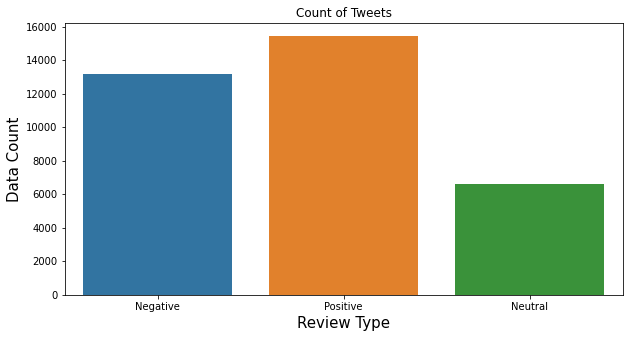

In [24]:
#@title Dataset Outcome Graph
ax = sns.countplot(x='Sentiment', data=dataset)


#Setting labels and font size
ax.set(xlabel='Review Type', ylabel='Data Count',title='Count of Tweets')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



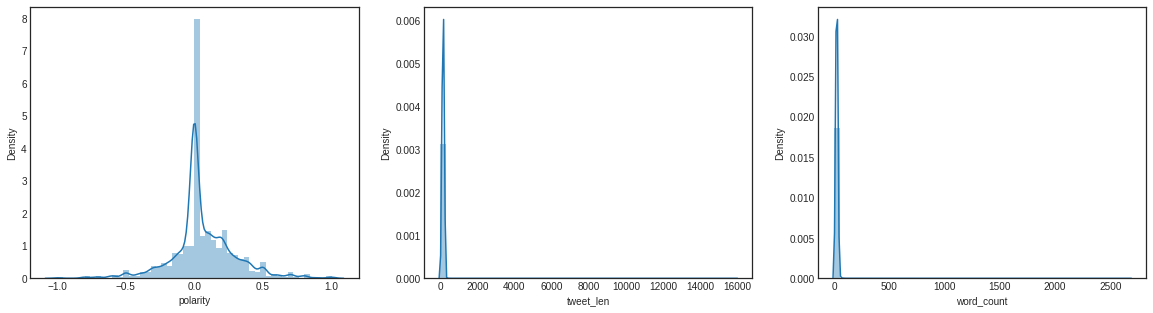

In [25]:
#Extracting the features from the news
df = []
df = dataset.copy()
df['polarity'] = df['OriginalTweet'].map(lambda text: TextBlob(text).sentiment.polarity)
df['tweet_len'] = df['OriginalTweet'].astype(str).apply(len)
df['word_count'] = df['OriginalTweet'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(df['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(df['tweet_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(df['word_count'])
fig = plt.gcf()


**TF-IDF model**

In [26]:
# @title Feature Extraction: TF-IDF Model
tfidf = TfidfVectorizer( ngram_range=(1,3), analyzer='char')
x = tfidf.fit_transform(dataset['OriginalTweet'])
y = dataset['Sentiment']
x.shape

(35174, 64749)

**Splitting Dataset**

In [27]:
# Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)

**Support Vector Machine**

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions

In [29]:
#@title Support Vector Machine
svm = LinearSVC()

ovr_classifier = OneVsRestClassifier(svm)

ovr_classifier.fit(x_train,y_train)
y_pred = ovr_classifier.predict(x_test)

In [30]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("\n")

svm_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % svm_accuracy)

svm_precision = precision_score(y_test, y_pred, average="macro", pos_label='positive')
print('Precision: %f' % svm_precision)

svm_recall = recall_score(y_test, y_pred, average="macro", pos_label='positive')
print('Recall: %f' % svm_recall)

svm_f1_score = f1_score(y_test, y_pred, average="macro", pos_label='positive')
print('F1 Score: %f' % svm_f1_score)


[[1883  197  560]
 [ 270  639  386]
 [ 479  199 2422]]


              precision    recall  f1-score   support

    Negative       0.72      0.71      0.71      2640
     Neutral       0.62      0.49      0.55      1295
    Positive       0.72      0.78      0.75      3100

    accuracy                           0.70      7035
   macro avg       0.68      0.66      0.67      7035
weighted avg       0.70      0.70      0.70      7035



Accuracy: 0.702772
Precision: 0.683979
Recall: 0.662661
F1 Score: 0.670585


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.



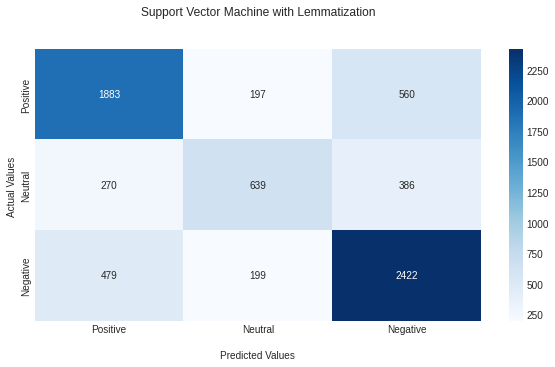

In [31]:
ax = sns.heatmap(cm,annot=True,cmap='Blues', fmt='g')

ax.set_title('Support Vector Machine with Lemmatization\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Neutral','Negative'])
ax.yaxis.set_ticklabels(['Positive','Neutral','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Logistic Regression**

In [32]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

In [33]:
# @title Logistic Regression
log = LogisticRegression(solver='saga', max_iter=1000)
ovr = OneVsRestClassifier(log)
ovr.fit(x_train, y_train)
y_pred = ovr.predict(x_test)

In [34]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("\n")

log_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % log_accuracy)

log_precision = precision_score(y_test, y_pred, average="macro", pos_label='positive')
print('Precision: %f' % log_precision)

log_recall = recall_score(y_test, y_pred, average="macro", pos_label='positive')
print('Recall: %f' % log_recall)

log_f1_score = f1_score(y_test, y_pred, average="macro", pos_label='positive')
print('F1 Score: %f' % log_f1_score)


[[1811  159  670]
 [ 283  581  431]
 [ 480  177 2443]]


              precision    recall  f1-score   support

    Negative       0.70      0.69      0.69      2640
     Neutral       0.63      0.45      0.53      1295
    Positive       0.69      0.79      0.74      3100

    accuracy                           0.69      7035
   macro avg       0.68      0.64      0.65      7035
weighted avg       0.68      0.69      0.68      7035



Accuracy: 0.687278
Precision: 0.675499
Recall: 0.640899
F1 Score: 0.651795


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.



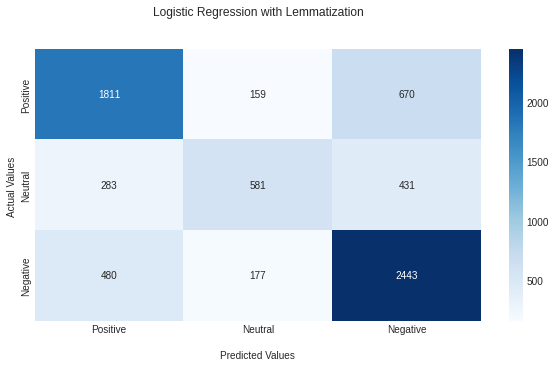

In [35]:
ax = sns.heatmap(cm,annot=True,cmap='Blues', fmt='g')

ax.set_title('Logistic Regression with Lemmatization\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Neutral','Negative'])
ax.yaxis.set_ticklabels(['Positive','Neutral','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Naive Bayes**

In [36]:
# @title Naive Bayes
# create and train the Naive Bayes Classifier
import numpy as np
from sklearn.datasets import make_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
ovr = OneVsRestClassifier(classifier)
ovr.fit(x_train, y_train)
y_pred = ovr.predict(x_test)

In [37]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("\n")

nb_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % nb_accuracy)

nb_precision = precision_score(y_test, y_pred, average="macro", pos_label='positive')
print('Precision: %f' % nb_precision)

nb_recall = recall_score(y_test, y_pred, average="macro", pos_label='positive')
print('Recall: %f' % nb_recall)

nb_f1_score = f1_score(y_test, y_pred, average="macro", pos_label='positive')
print('F1 Score: %f' % nb_f1_score)

[[ 657    2 1981]
 [  99   10 1186]
 [ 107    0 2993]]


              precision    recall  f1-score   support

    Negative       0.76      0.25      0.38      2640
     Neutral       0.83      0.01      0.02      1295
    Positive       0.49      0.97      0.65      3100

    accuracy                           0.52      7035
   macro avg       0.69      0.41      0.35      7035
weighted avg       0.65      0.52      0.43      7035



Accuracy: 0.520256
Precision: 0.693503
Recall: 0.407357
F1 Score: 0.345615


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.



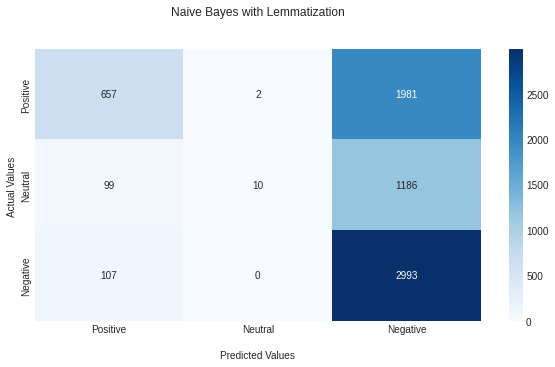

In [38]:
ax = sns.heatmap(cm,annot=True,cmap='Blues', fmt='g')

ax.set_title('Naive Bayes with Lemmatization\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Neutral','Negative'])
ax.yaxis.set_ticklabels(['Positive','Neutral','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Random Forest**

In [39]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

In [40]:
# @title Random Forest
rf = RandomForestClassifier(n_estimators=10,criterion = 'gini', random_state=0)
ovr = OneVsRestClassifier(rf)
ovr.fit(x_train, y_train)
y_pred = ovr.predict(x_test)


In [41]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("\n")

rf_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % rf_accuracy)

rf_precision = precision_score(y_test, y_pred, average="macro", pos_label='positive')
print('Precision: %f' % rf_precision)

rf_recall = recall_score(y_test, y_pred, average="macro", pos_label='positive')
print('Recall: %f' % rf_recall)

rf_f1_score = f1_score(y_test, y_pred, average="macro", pos_label='positive')
print('F1 Score: %f' % rf_f1_score)


[[1180  170 1290]
 [ 291  350  654]
 [ 550  166 2384]]


              precision    recall  f1-score   support

    Negative       0.58      0.45      0.51      2640
     Neutral       0.51      0.27      0.35      1295
    Positive       0.55      0.77      0.64      3100

    accuracy                           0.56      7035
   macro avg       0.55      0.50      0.50      7035
weighted avg       0.56      0.56      0.54      7035



Accuracy: 0.556361
Precision: 0.548302
Recall: 0.495424
F1 Score: 0.500527


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.



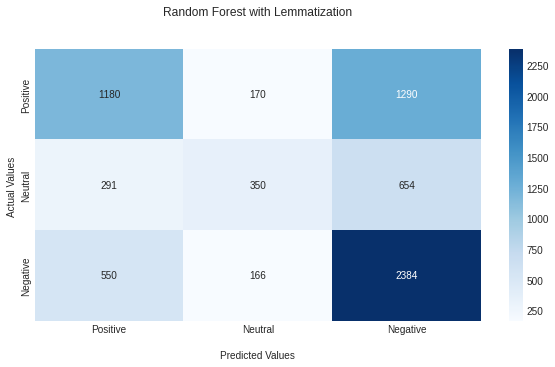

In [42]:
ax = sns.heatmap(cm,annot=True,cmap='Blues', fmt='g')

ax.set_title('Random Forest with Lemmatization\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Neutral','Negative'])
ax.yaxis.set_ticklabels(['Positive','Neutral','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()

**XGBoost**

In [43]:
# @title XGBoost
xgb = XGBClassifier()
ovr = OneVsRestClassifier(xgb)
ovr.fit(x_train, y_train)
y_pred = ovr.predict(x_test)

In [45]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("\n")

xgb_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % xgb_accuracy)

xgb_precision = precision_score(y_test, y_pred, average="macro", pos_label='positive')
print('Precision: %f' % xgb_precision)

xgb_recall = recall_score(y_test, y_pred, average="macro", pos_label='positive')
print('Recall: %f' % xgb_recall)

xgb_f1_score = f1_score(y_test, y_pred, average="macro", pos_label='positive')
print('F1 Score: %f' % xgb_f1_score)


[[1687  179  774]
 [ 304  539  452]
 [ 520  194 2386]]


              precision    recall  f1-score   support

    Negative       0.67      0.64      0.66      2640
     Neutral       0.59      0.42      0.49      1295
    Positive       0.66      0.77      0.71      3100

    accuracy                           0.66      7035
   macro avg       0.64      0.61      0.62      7035
weighted avg       0.65      0.66      0.65      7035



Accuracy: 0.655579
Precision: 0.641143
Recall: 0.608303
F1 Score: 0.618143


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.



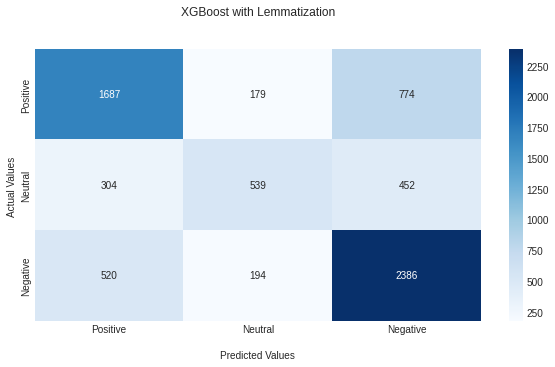

In [46]:
ax = sns.heatmap(cm,annot=True,cmap='Blues', fmt='g')

ax.set_title('XGBoost with Lemmatization\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Neutral','Negative'])
ax.yaxis.set_ticklabels(['Positive','Neutral','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Comparision Graphs**

       Score       SVM        LR        NB        RF       XGB
0  Accuracy   0.702772  0.687278  0.520256  0.556361  0.655579
1  Precision  0.683979  0.675499  0.693503  0.548302  0.641143
2  Recall     0.662661  0.640899  0.407357  0.495424  0.608303
3  F1 Score   0.670585  0.651795  0.345615  0.500527  0.618143





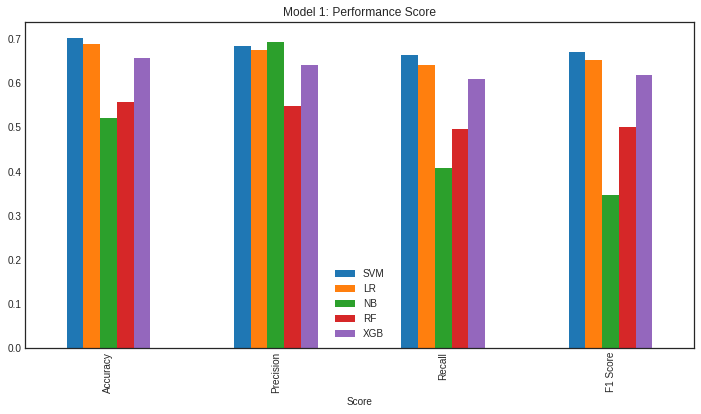

In [47]:
# @title Comparision Graphs


cmpDf = pd.DataFrame([['Accuracy', svm_accuracy, log_accuracy,nb_accuracy, rf_accuracy, xgb_accuracy], 
                      ['Precision', svm_precision, log_precision,nb_precision, rf_precision, xgb_precision], 
                      ['Recall', svm_recall, log_recall,nb_recall, rf_recall, xgb_recall],
                      ['F1 Score', svm_f1_score, log_f1_score,nb_f1_score, rf_f1_score, xgb_f1_score]],
                  columns=['Score', 'SVM', 'LR', 'NB', 'RF', 'XGB'])
# view data
print(cmpDf)
print("\n\n")

# plot grouped bar chart
ax = cmpDf.plot(x='Score',
        figsize=(12,6),
        kind='bar',
        stacked=False,
        title='Model 1: Performance Score')


**Bag of Words**

In [48]:
# @title Feature Extraction: BOW Model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000)
x = cv.fit_transform(dataset['OriginalTweet'])
y = dataset['Sentiment']
x.shape

(35174, 2000)

**Splitting Dataset**

In [49]:
# Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)

**Support Vector Machine**

In [50]:
#@title Support Vector Machine
svm = LinearSVC()

ovr_classifier = OneVsRestClassifier(svm)

ovr_classifier.fit(x_train,y_train)
y_pred = ovr_classifier.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [51]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("\n")

svm_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % svm_accuracy)

svm_precision = precision_score(y_test, y_pred, average="macro", pos_label='positive')
print('Precision: %f' % svm_precision)

svm_recall = recall_score(y_test, y_pred, average="macro", pos_label='positive')
print('Recall: %f' % svm_recall)

svm_f1_score = f1_score(y_test, y_pred, average="macro", pos_label='positive')
print('F1 Score: %f' % svm_f1_score)


[[2089  214  337]
 [ 183  906  206]
 [ 303  207 2590]]


              precision    recall  f1-score   support

    Negative       0.81      0.79      0.80      2640
     Neutral       0.68      0.70      0.69      1295
    Positive       0.83      0.84      0.83      3100

    accuracy                           0.79      7035
   macro avg       0.77      0.78      0.77      7035
weighted avg       0.79      0.79      0.79      7035



Accuracy: 0.793888
Precision: 0.773563
Recall: 0.775462
F1 Score: 0.774429


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.



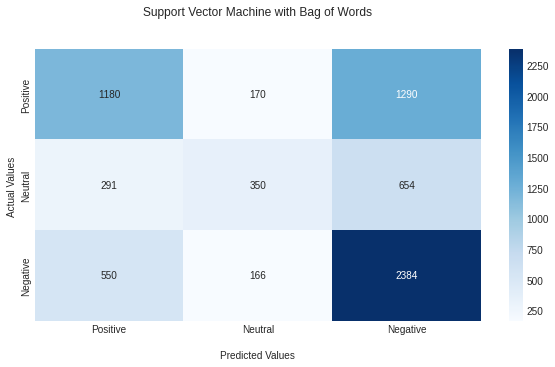

In [44]:
ax = sns.heatmap(cm,annot=True,cmap='Blues', fmt='g')

ax.set_title('Support Vector Machine with Bag of Words\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Neutral','Negative'])
ax.yaxis.set_ticklabels(['Positive','Neutral','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Logistic Regression**

In [52]:
# @title Logistic Regression
log = LogisticRegression(solver='saga', max_iter=1000)
ovr = OneVsRestClassifier(log)
ovr.fit(x_train, y_train)
y_pred = ovr.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [53]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("\n")

log_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % log_accuracy)

log_precision = precision_score(y_test, y_pred, average="macro", pos_label='positive')
print('Precision: %f' % log_precision)

log_recall = recall_score(y_test, y_pred, average="macro", pos_label='positive')
print('Recall: %f' % log_recall)

log_f1_score = f1_score(y_test, y_pred, average="macro", pos_label='positive')
print('F1 Score: %f' % log_f1_score)


[[2063  166  411]
 [ 225  799  271]
 [ 336  159 2605]]


              precision    recall  f1-score   support

    Negative       0.79      0.78      0.78      2640
     Neutral       0.71      0.62      0.66      1295
    Positive       0.79      0.84      0.82      3100

    accuracy                           0.78      7035
   macro avg       0.76      0.75      0.75      7035
weighted avg       0.78      0.78      0.78      7035



Accuracy: 0.777114
Precision: 0.763191
Recall: 0.746250
F1 Score: 0.753379


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.



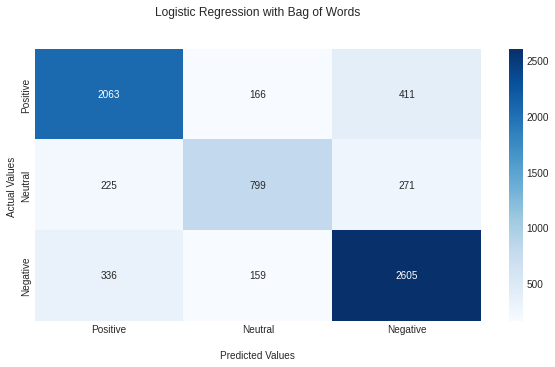

In [55]:
ax = sns.heatmap(cm,annot=True,cmap='Blues', fmt='g')

ax.set_title('Logistic Regression with Bag of Words\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Neutral','Negative'])
ax.yaxis.set_ticklabels(['Positive','Neutral','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Naive Bayes**

In [56]:
# create and train the Naive Bayes Classifier
# @title Naive Bayes
import numpy as np
from sklearn.datasets import make_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
ovr = OneVsRestClassifier(classifier)
ovr.fit(x_train, y_train)
y_pred = ovr.predict(x_test)

In [57]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("\n")

nb_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % nb_accuracy)

nb_precision = precision_score(y_test, y_pred, average="macro", pos_label='positive')
print('Precision: %f' % nb_precision)

nb_recall = recall_score(y_test, y_pred, average="macro", pos_label='positive')
print('Recall: %f' % nb_recall)

nb_f1_score = f1_score(y_test, y_pred, average="macro", pos_label='positive')
print('F1 Score: %f' % nb_f1_score)

[[1902  253  485]
 [ 279  698  318]
 [ 482  291 2327]]


              precision    recall  f1-score   support

    Negative       0.71      0.72      0.72      2640
     Neutral       0.56      0.54      0.55      1295
    Positive       0.74      0.75      0.75      3100

    accuracy                           0.70      7035
   macro avg       0.67      0.67      0.67      7035
weighted avg       0.70      0.70      0.70      7035



Accuracy: 0.700355
Precision: 0.673226
Recall: 0.670032
F1 Score: 0.671539


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.



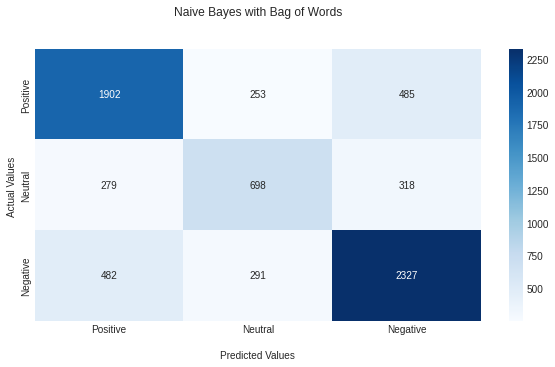

In [58]:
ax = sns.heatmap(cm,annot=True,cmap='Blues', fmt='g')

ax.set_title('Naive Bayes with Bag of Words\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Neutral','Negative'])
ax.yaxis.set_ticklabels(['Positive','Neutral','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Random Forest**

In [59]:
# @title Random Forest
rf = RandomForestClassifier(n_estimators=10,criterion = 'gini', random_state=0)
ovr = OneVsRestClassifier(rf)
ovr.fit(x_train, y_train)
y_pred = ovr.predict(x_test)


In [60]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("\n")

rf_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % rf_accuracy)

rf_precision = precision_score(y_test, y_pred, average="macro", pos_label='positive')
print('Precision: %f' % rf_precision)

rf_recall = recall_score(y_test, y_pred, average="macro", pos_label='positive')
print('Recall: %f' % rf_recall)

rf_f1_score = f1_score(y_test, y_pred, average="macro", pos_label='positive')
print('F1 Score: %f' % rf_f1_score)


[[1817  213  610]
 [ 190  822  283]
 [ 329  149 2622]]


              precision    recall  f1-score   support

    Negative       0.78      0.69      0.73      2640
     Neutral       0.69      0.63      0.66      1295
    Positive       0.75      0.85      0.79      3100

    accuracy                           0.75      7035
   macro avg       0.74      0.72      0.73      7035
weighted avg       0.75      0.75      0.75      7035



Accuracy: 0.747832
Precision: 0.739343
Recall: 0.722938
F1 Score: 0.728740


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.



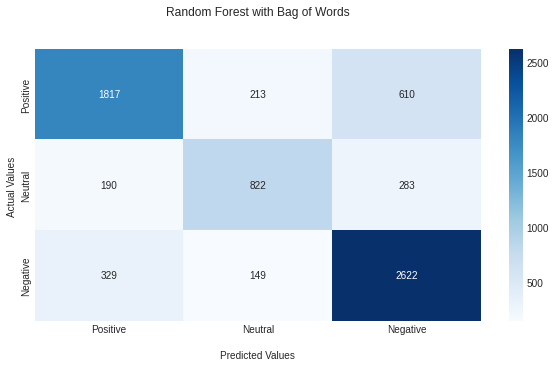

In [62]:
ax = sns.heatmap(cm,annot=True,cmap='Blues', fmt='g')

ax.set_title('Random Forest with Bag of Words\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Neutral','Negative'])
ax.yaxis.set_ticklabels(['Positive','Neutral','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()

**XGBoost**

In [63]:
# @title XGBoost
xgb = XGBClassifier()
ovr = OneVsRestClassifier(xgb)
ovr.fit(x_train, y_train)
y_pred = ovr.predict(x_test)

In [64]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("\n")

xgb_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % xgb_accuracy)

xgb_precision = precision_score(y_test, y_pred, average="macro", pos_label='positive')
print('Precision: %f' % xgb_precision)

xgb_recall = recall_score(y_test, y_pred, average="macro", pos_label='positive')
print('Recall: %f' % xgb_recall)

xgb_f1_score = f1_score(y_test, y_pred, average="macro", pos_label='positive')
print('F1 Score: %f' % xgb_f1_score)


[[1773   13  854]
 [ 267   54  974]
 [ 419   17 2664]]


              precision    recall  f1-score   support

    Negative       0.72      0.67      0.70      2640
     Neutral       0.64      0.04      0.08      1295
    Positive       0.59      0.86      0.70      3100

    accuracy                           0.64      7035
   macro avg       0.65      0.52      0.49      7035
weighted avg       0.65      0.64      0.58      7035



Accuracy: 0.638380
Precision: 0.652312
Recall: 0.524215
F1 Score: 0.491846


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning:

Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.



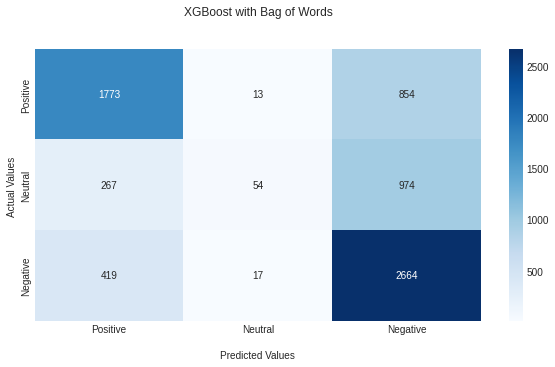

In [65]:
ax = sns.heatmap(cm,annot=True,cmap='Blues', fmt='g')

ax.set_title('XGBoost with Bag of Words\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Neutral','Negative'])
ax.yaxis.set_ticklabels(['Positive','Neutral','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Comparision Graphs**

       Score       SVM        LR        NB        RF       XGB
0  Accuracy   0.793888  0.777114  0.700355  0.747832  0.638380
1  Precision  0.773563  0.763191  0.673226  0.739343  0.652312
2  Recall     0.775462  0.746250  0.670032  0.722938  0.524215
3  F1 Score   0.774429  0.753379  0.671539  0.728740  0.491846





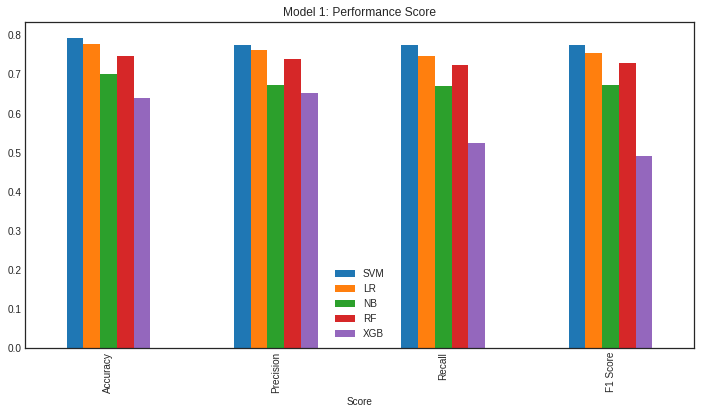

In [66]:
# @title Comparision Graphs


cmpDf = pd.DataFrame([['Accuracy', svm_accuracy, log_accuracy,nb_accuracy, rf_accuracy, xgb_accuracy], 
                      ['Precision', svm_precision, log_precision,nb_precision, rf_precision, xgb_precision], 
                      ['Recall', svm_recall, log_recall,nb_recall, rf_recall, xgb_recall],
                      ['F1 Score', svm_f1_score, log_f1_score,nb_f1_score, rf_f1_score, xgb_f1_score]],
                  columns=['Score', 'SVM', 'LR','NB', 'RF', 'XGB'])
# view data
print(cmpDf)
print("\n\n")

# plot grouped bar chart
ax = cmpDf.plot(x='Score',
        figsize=(12,6),
        kind='bar',
        stacked=False,
        title='Model 1: Performance Score')
